# Minimierung der Durschlaufzeit (Flow Time) jedes Produktionsauftrags
- Es liegen Ankunftszeiten 'Arrival' vor, aber es werden speziell die frühsten Bearbeitungszeiten 'Ready Time' verwedendet, um die Kausalität zu bewahren, dass bereits angekommene Aufträge (Jobs) geplant werden können.
- Die 'Ready Time' sind auf den nächsten Tagesbeginn bzw. Schichtbeginn aufgerundete Ankunftszeiten

In [2]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check
from src.utils.new_filter import *

# Solver Model
from src.models.lp import flowtime_scheduling as lp_ft_schedule
from src.models.lp import flowtime_rescheduling as lp_ft_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [3]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*10     # 10 min

# Simulation
simulation = ProductionSimulation(sigma = 0.25)

In [4]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


## I. Generierung der Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [5]:
# Generierung auf Basis von den Arbeitsplänen (Routings) und der Vorgabe bestimmten Parameter, insbesondere der Maximalauslastung (95 %)
df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 2, shift_length = 1440,
                                                        u_b_mmax = 0.95, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
1,J25-0001,6,123,1440
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
5,J25-0005,1,472,1440
...,...,...,...,...
33,J25-0033,2,2520,2880
34,J25-0034,8,2572,2880
35,J25-0035,5,2583,2880


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [6]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [7]:
# "neue" und unerledigte Jobs
df_jobs_arrivals_current = get_current_jobs(
    df_jobs_arrivals, df_previous_not_started = None, ready_time=day_start
)
df_jobs_arrivals_current

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
1,J25-0001,6,123,1440
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
5,J25-0005,1,472,1440
...,...,...,...,...
11,J25-0011,1,976,1440
12,J25-0012,2,1045,1440
13,J25-0013,3,1129,1440


In [8]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_arrivals_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
164,J25-0016,6,4,M06,32
165,J25-0016,6,5,M05,21
166,J25-0016,6,6,M09,32


### Scheduling

In [9]:
# Scheduling
df_schedule = lp_ft_schedule.solve_jssp(
    df_jssp_current, df_jobs_arrivals_current, solver= "HiGHS",
    var_cat="Integer", msg=False, earliest_start_column = "Ready Time",
    timeLimit=max_time, gapRel= 0.05)
df_schedule

BigM: 9000

Solver-Informationen:
  Summe Flow Times        : 17915.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1547
  Anzahl Constraints      : 2890
  Laufzeit                : ~600.20 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0000,8,0,M00,76,75,1440,2062.0,2138.0
1,J25-0000,8,1,M01,69,75,1440,2299.0,2368.0
2,J25-0000,8,2,M03,76,75,1440,2532.0,2608.0
3,J25-0000,8,3,M05,51,75,1440,2608.0,2659.0
4,J25-0000,8,4,M02,85,75,1440,2690.0,2775.0
5,J25-0000,8,5,M09,11,75,1440,2775.0,2786.0
...,...,...,...,...,...,...,...,...,...
164,J25-0016,6,4,M06,32,1421,1440,1597.0,1629.0
165,J25-0016,6,5,M05,21,1421,1440,1653.0,1674.0
166,J25-0016,6,6,M09,32,1421,1440,1674.0,1706.0


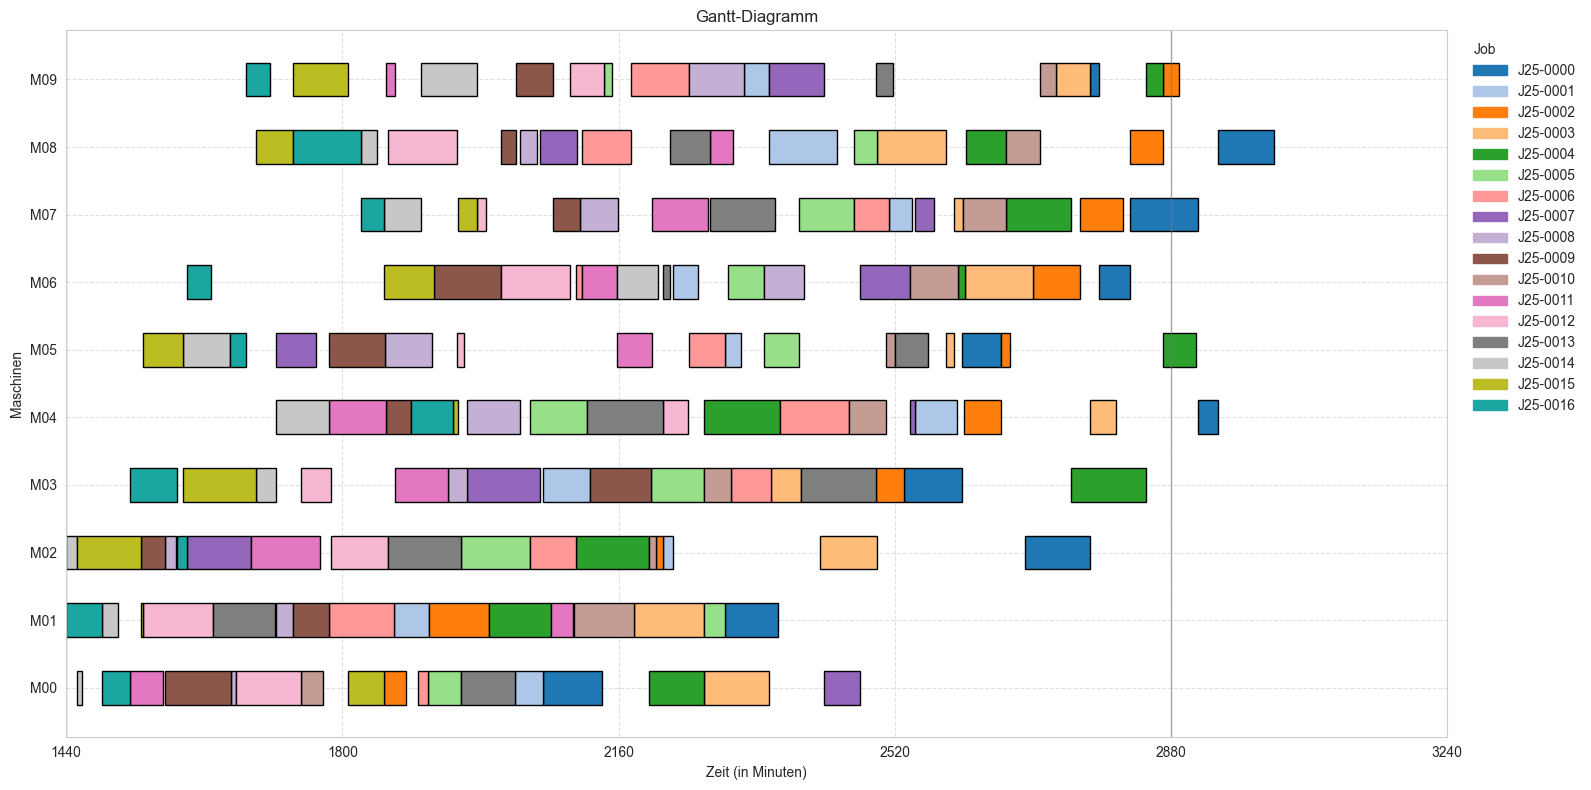

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [11]:
df_schedule.to_csv(basic_data_path / "schedule_example_day_00.csv", index=False)

### Simulation

In [12]:
simulation.run(dframe_schedule_plan= df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0014 started on M02
[Day 1 00:00:00] Job J25-0016 started on M01
[Day 1 00:22:00] Job J25-0014 finished on M02 (after 22 minutes)
[Day 1 00:22:00] Job J25-0015 started on M02
[Day 1 00:22:00] Job J25-0014 started on M00
[Day 1 00:29:00] Job J25-0014 finished on M00 (after 07 minutes)
[Day 1 00:45:00] Job J25-0016 finished on M01 (after 45 minutes)
[Day 1 00:46:00] Job J25-0014 started on M01
[Day 1 00:46:00] Job J25-0016 started on M00
[Day 1 01:16:00] Job J25-0014 finished on M01 (after 30 minutes)
[Day 1 01:23:00] Job J25-0016 finished on M00 (after 37 minutes)
[Day 1 01:23:00] Job J25-0011 started on M00
[Day 1 01:23:00] Job J25-0016 started on M03
[Day 1 01:40:00] Job J25-0012 started on M01
[Day 1 02:06:00] Job J25-0015 finished on M02 (after 104 minutes)
[Day 1 02:06:00] Job J25-0011 finished on M00 (after 43 minutes)
[Day 1 02:06:00] Job J25-0009 started on M02
[Day 1 02:26:00] Job J25-0016 finished on M03 (after 63 minutes)
[Day 1 02:32:00] Job J25-0014

In [13]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,8,J25-0000,0,M00,75,2084.0,57.0,2141.0
1,8,J25-0000,1,M01,75,2332.0,98.0,2430.0
2,8,J25-0000,2,M03,75,2666.0,67.0,2733.0
3,8,J25-0000,3,M05,75,2733.0,48.0,2781.0
4,6,J25-0001,0,M01,123,1902.0,34.0,1936.0
5,6,J25-0001,1,M00,123,2044.0,40.0,2084.0
...,...,...,...,...,...,...,...,...
151,6,J25-0016,4,M06,1421,1615.0,32.0,1647.0
152,6,J25-0016,5,M05,1421,1668.0,17.0,1685.0
153,6,J25-0016,6,M09,1421,1685.0,30.0,1715.0


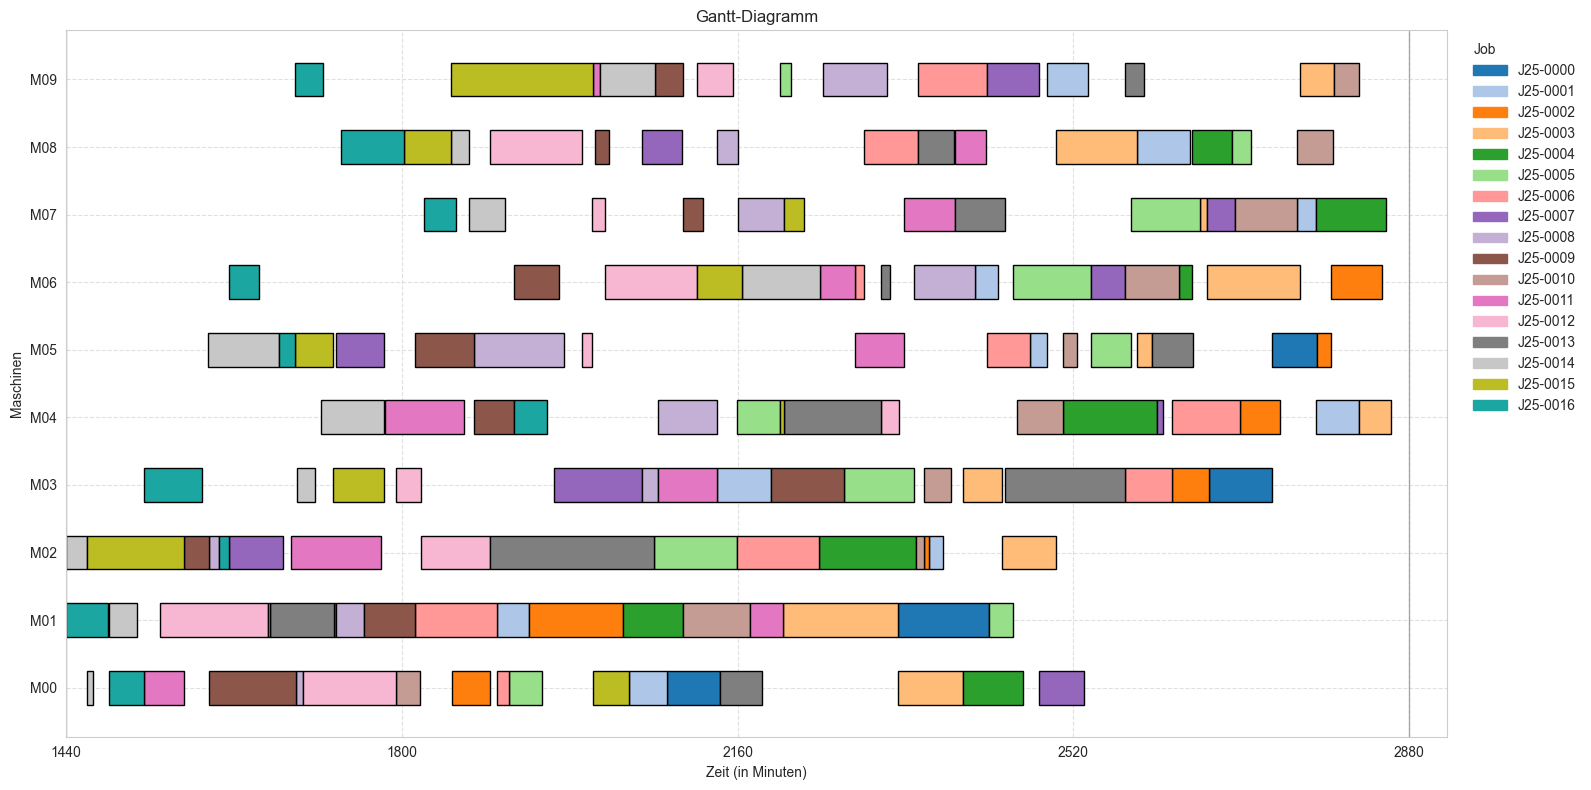

In [14]:
show.plot_gantt(df_execution, perspective="Machine")

In [15]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0000,4,M02,75,2781.0,85,115.0,2866.0,2896.0
1,J25-0004,7,M03,271,2856.0,98,110.0,2954.0,2966.0
2,J25-0006,9,M07,749,2856.0,45,48.0,2901.0,2904.0


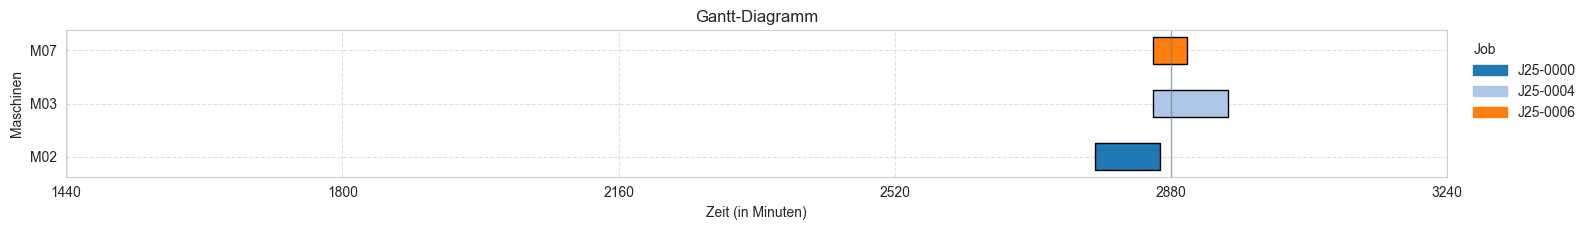

In [16]:
show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [17]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0000,8,5,M09,11,75,1440,2775.0,2786.0
1,J25-0000,8,6,M06,40,75,1440,2786.0,2826.0
2,J25-0000,8,7,M07,89,75,1440,2826.0,2915.0
3,J25-0000,8,8,M04,26,75,1440,2915.0,2941.0
4,J25-0000,8,9,M08,74,75,1440,2941.0,3015.0
5,J25-0002,0,7,M07,56,187,1440,2762.0,2818.0
6,J25-0002,0,8,M08,44,187,1440,2826.0,2870.0
7,J25-0002,0,9,M09,21,187,1440,2870.0,2891.0
8,J25-0004,3,8,M09,22,271,1440,2848.0,2870.0
9,J25-0004,3,9,M05,43,271,1440,2870.0,2913.0


## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [18]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [19]:
df_not_started["Job"].unique()

array(['J25-0000', 'J25-0002', 'J25-0004'], dtype=object)

In [20]:
# "neue" und unerledigte Jobs
df_jobs_arrivals_current = get_current_jobs(df_jobs_arrivals, df_not_started, ready_time=day_start)
df_jobs_arrivals_current

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
2,J25-0002,0,187,1440
4,J25-0004,3,271,1440
17,J25-0017,7,1766,2880
18,J25-0018,8,1818,2880
19,J25-0019,9,1823,2880
...,...,...,...,...
33,J25-0033,2,2520,2880
34,J25-0034,8,2572,2880
35,J25-0035,5,2583,2880


In [21]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_arrivals_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
7,J25-0000,8,7,M07,89
8,J25-0000,8,8,M04,26
9,J25-0000,8,9,M08,74
27,J25-0002,0,7,M07,56
...,...,...,...,...,...
384,J25-0038,3,4,M06,9
385,J25-0038,3,5,M08,52
386,J25-0038,3,6,M07,85


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [22]:
df_schedule_simple = lp_ft_reschedule.solve_jssp_with_fixed_ops(df_jssp_current, df_jobs_arrivals_current,
                                                           df_active, reschedule_start = day_start,
                                                           solver= "HiGHS", msg=False,
                                                           timeLimit=max_time, gapRel= 0.10)
df_schedule_simple

BigM: 15000

Solver-Informationen:
  Summe Flow Times        : 54171.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2858
  Anzahl Constraints      : 5461
  Laufzeit                : ~600.31 Sekunden


,Job,Routing_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,J25-0000,8,5,75,M09,2896.0,11.0,2832.0,2907.0
1,J25-0000,8,6,75,M06,2907.0,40.0,2872.0,2947.0
2,J25-0000,8,7,75,M07,2960.0,89.0,2974.0,3049.0
3,J25-0000,8,8,75,M04,3049.0,26.0,3000.0,3075.0
4,J25-0000,8,9,75,M08,3356.0,74.0,3355.0,3430.0
5,J25-0002,0,7,187,M07,2904.0,56.0,2773.0,2960.0
...,...,...,...,...,...,...,...,...,...
224,J25-0038,3,4,2815,M06,3535.0,9.0,729.0,3544.0
225,J25-0038,3,5,2815,M08,3544.0,52.0,781.0,3596.0
226,J25-0038,3,6,2815,M07,3596.0,85.0,866.0,3681.0


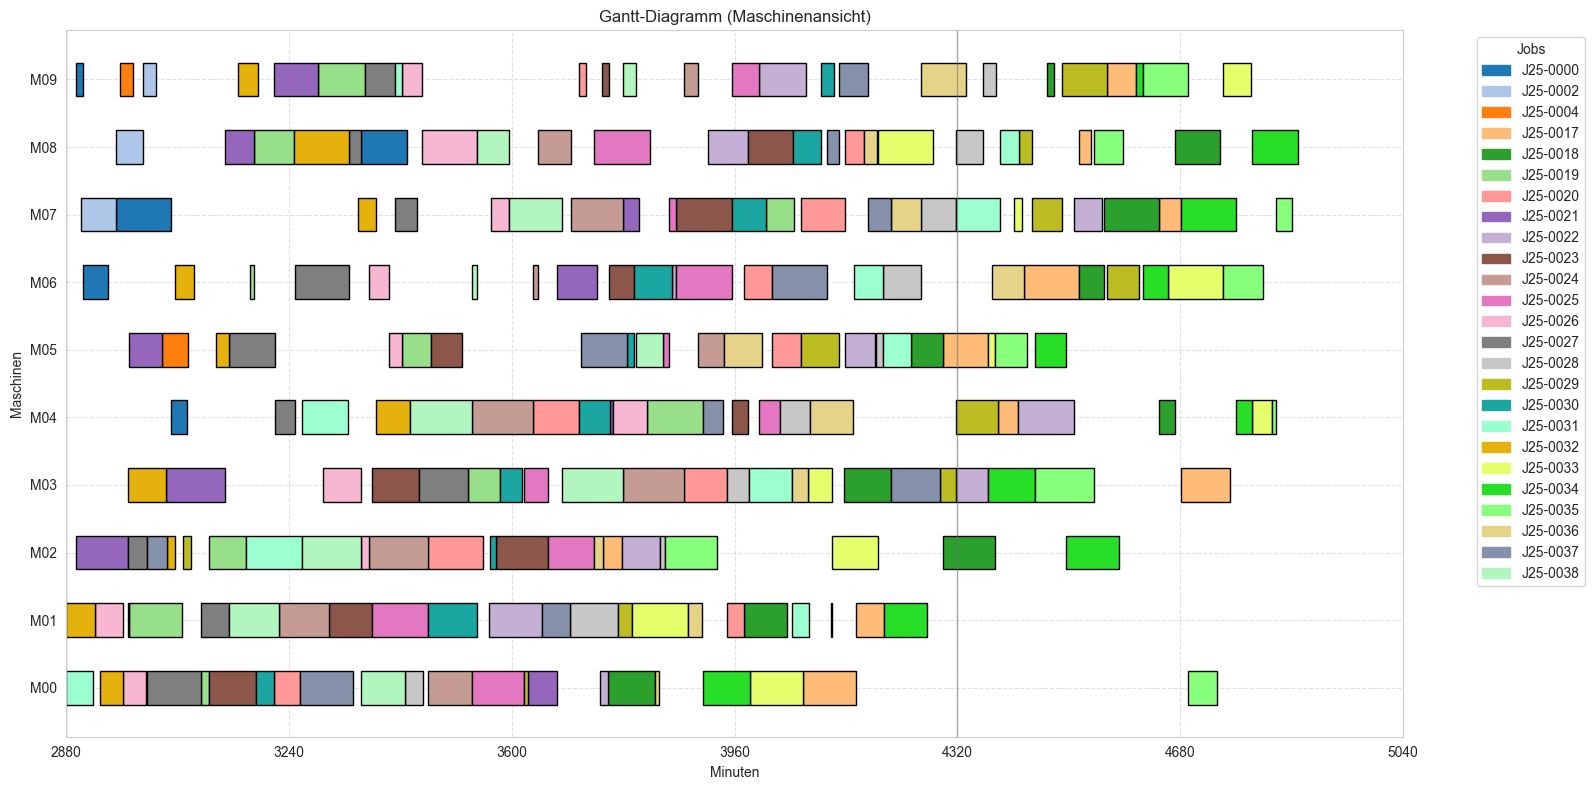

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

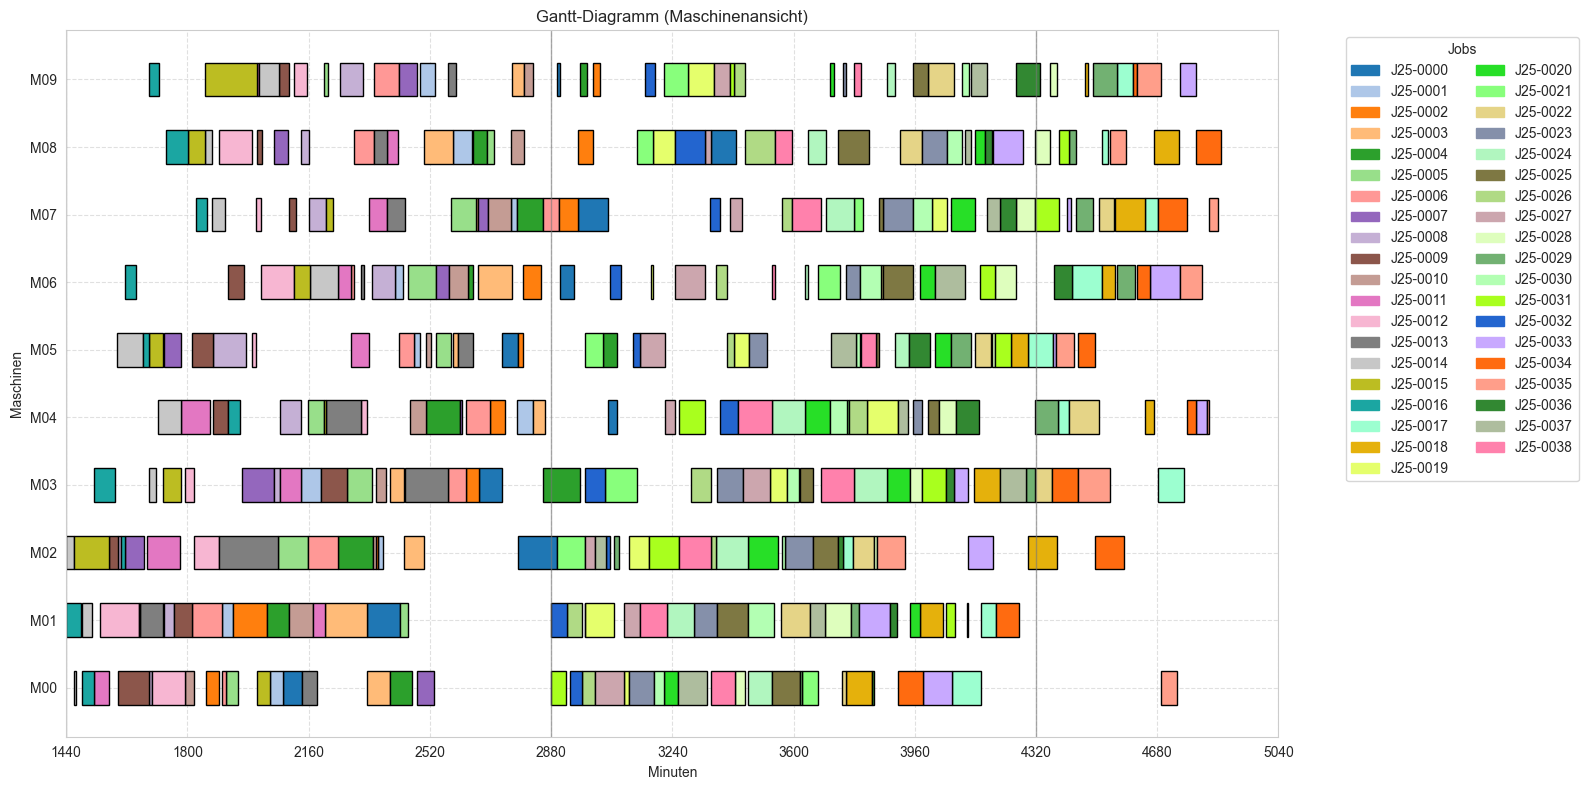

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [24]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [25]:
df_schedule_devpen = lp_ft_reschedule.solve_jssp_with_devpen(df_jssp_current, df_jobs_arrivals_current, df_active,
                                                             df_original_plan = df_schedule, r = 0.60, # 60% Flowtime, 40% Abweichung
                                                             reschedule_start = day_start, solver= "HiGHS",
                                                             msg=False, timeLimit=max_time, gapRel= 0.02)
df_schedule_devpen

BigM: 15000

Solver-Informationen:
  Zielfunktionswert       : 32181.6
  Solver-Status           : Optimal
  Anzahl Variablen        : 2868
  Anzahl Constraints      : 5481
  Laufzeit                : ~600.28 Sekunden


,Job,Routing_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,J25-0000,8,5,75,M09,2896.0,11.0,2832.0,2907.0
1,J25-0000,8,6,75,M06,2907.0,40.0,2872.0,2947.0
2,J25-0000,8,7,75,M07,2960.0,89.0,2974.0,3049.0
3,J25-0000,8,8,75,M04,3049.0,26.0,3000.0,3075.0
4,J25-0000,8,9,75,M08,3075.0,74.0,3074.0,3149.0
5,J25-0002,0,7,187,M07,2904.0,56.0,2773.0,2960.0
...,...,...,...,...,...,...,...,...,...
224,J25-0038,3,4,2815,M06,4529.0,9.0,1723.0,4538.0
225,J25-0038,3,5,2815,M08,4544.0,52.0,1781.0,4596.0
226,J25-0038,3,6,2815,M07,4664.0,85.0,1934.0,4749.0


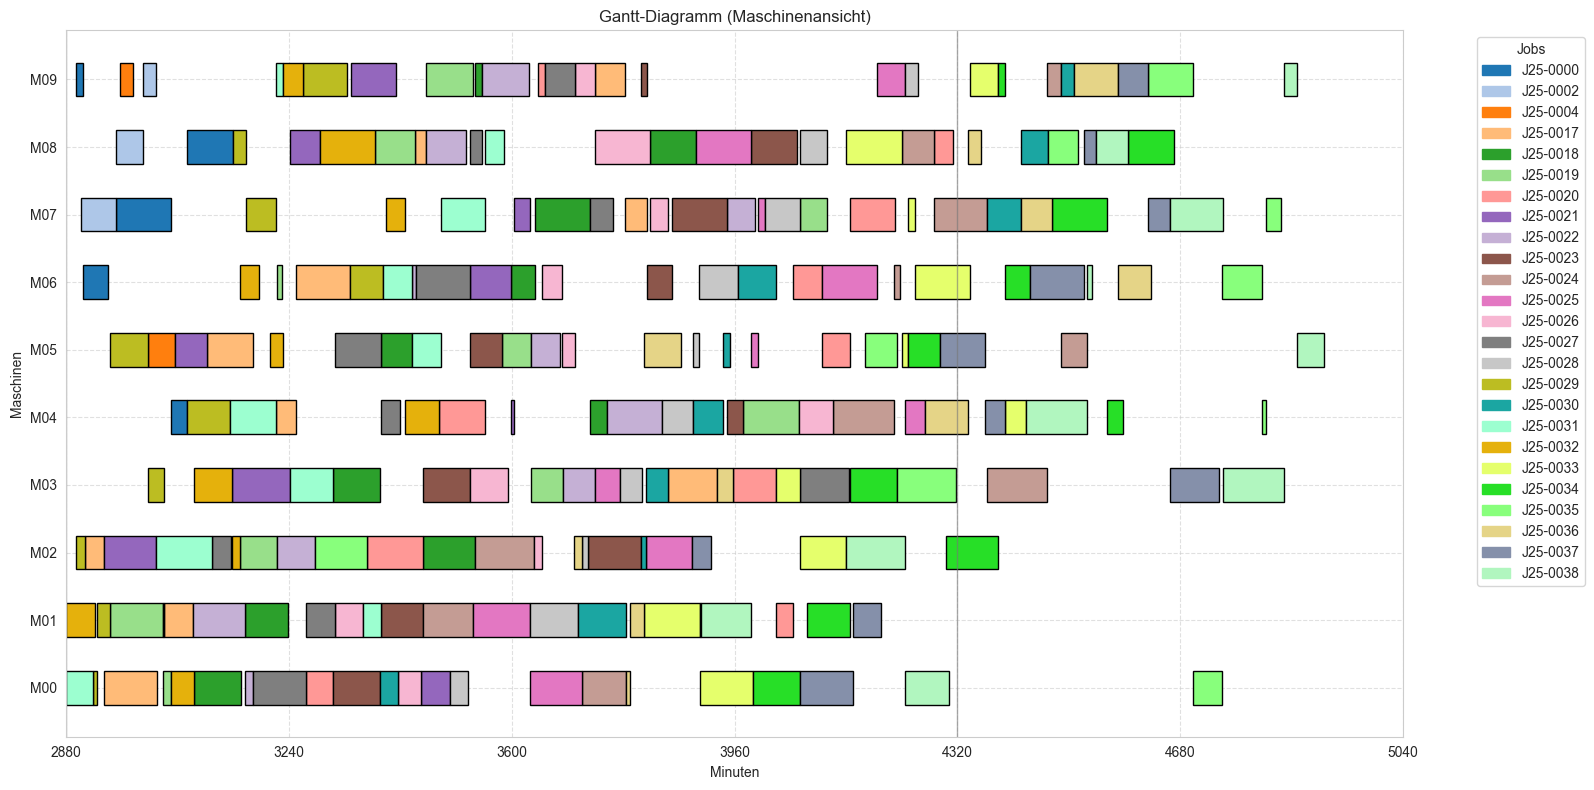

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [26]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

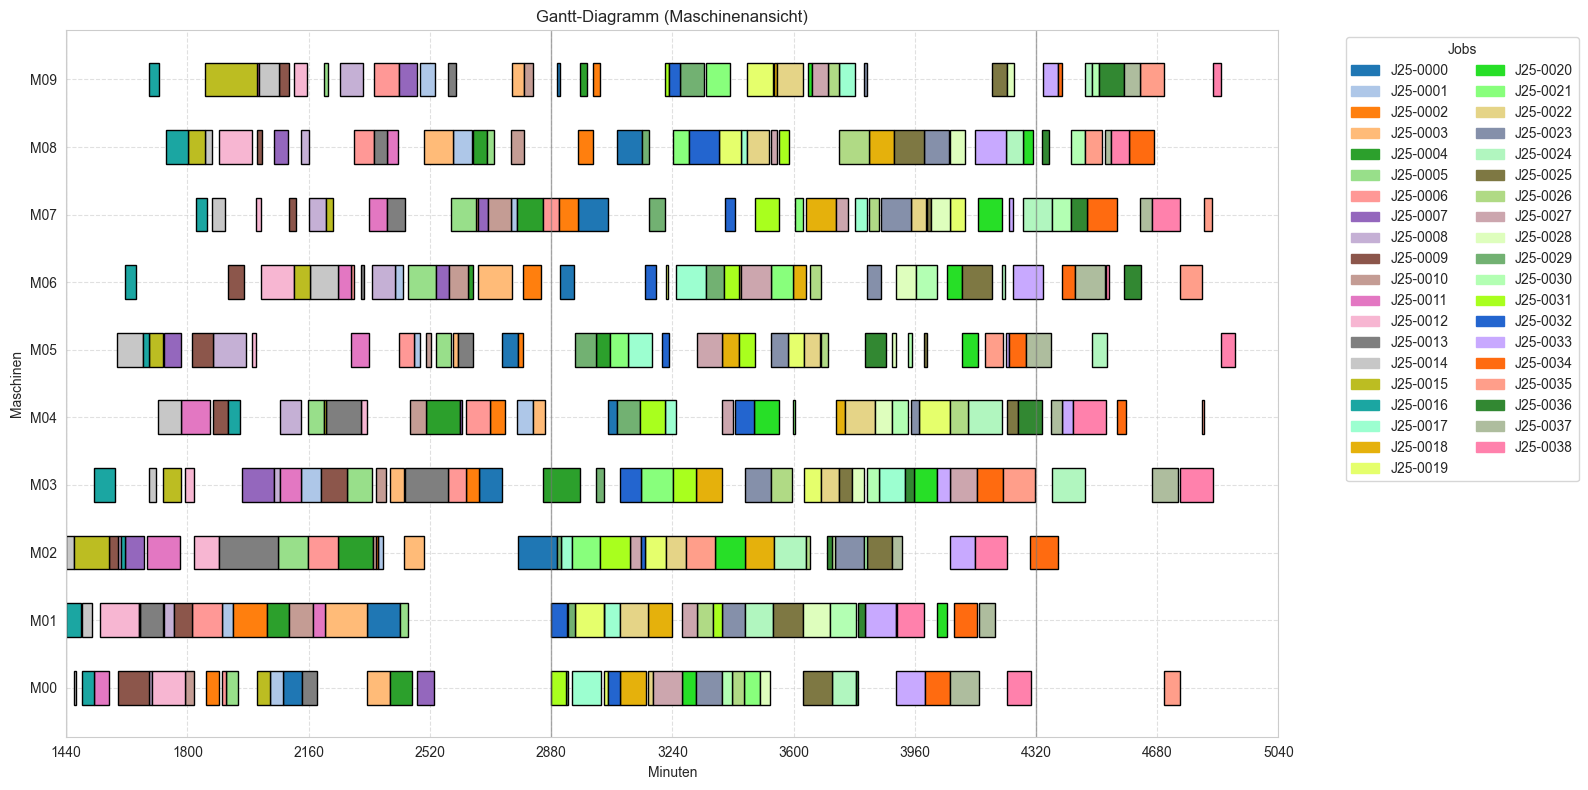

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [27]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [28]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0000, Operation 4 resumed with 16.00 min
[Day 2 00:00:00] Job J25-0006, Operation 9 resumed with 24.00 min
[Day 2 00:00:00] Job J25-0004, Operation 7 resumed with 86.00 min
[Day 2 00:00:00] Job J25-0031 started on M00
[Day 2 00:00:00] Job J25-0032 started on M01
[Day 2 00:16:00] Job J25-0000 finished on M02 (after 16 minutes)
[Day 2 00:16:00] Job J25-0000 started on M09
[Day 2 00:16:00] Job J25-0029 started on M02
[Day 2 00:24:00] Job J25-0006 finished on M07 (after 24 minutes)
[Day 2 00:24:00] Job J25-0002 started on M07
[Day 2 00:30:00] Job J25-0029 finished on M02 (after 14 minutes)
[Day 2 00:30:00] Job J25-0017 started on M02
[Day 2 00:31:00] Job J25-0000 finished on M09 (after 15 minutes)
[Day 2 00:31:00] Job J25-0000 started on M06
[Day 2 00:33:00] Job J25-0032 finished on M01 (after 33 minutes)
[Day 2 00:35:00] Job J25-0031 finished on M00 (after 35 minutes)
[Day 2 00:43:00] Job J25-0029 started on M00
[Day 2 00:48:00] Job J25-0029 finished on M00 (after

In [29]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Routing_ID
0,J25-0000,4,M02,75,2781.0,115.0,2896.0,NaN
1,J25-0000,5,M09,75,2896.0,15.0,2911.0,8.0
2,J25-0000,6,M06,75,2911.0,31.0,2942.0,8.0
3,J25-0000,7,M07,75,2960.0,68.0,3028.0,8.0
4,J25-0000,8,M04,75,3049.0,23.0,3072.0,8.0
5,J25-0000,9,M08,75,3075.0,85.0,3160.0,8.0
...,...,...,...,...,...,...,...,...
169,J25-0037,0,M02,2654,3927.0,19.0,3946.0,7.0
170,J25-0037,1,M00,2654,4088.0,127.0,4215.0,7.0
171,J25-0037,2,M01,2654,4215.0,48.0,4263.0,7.0


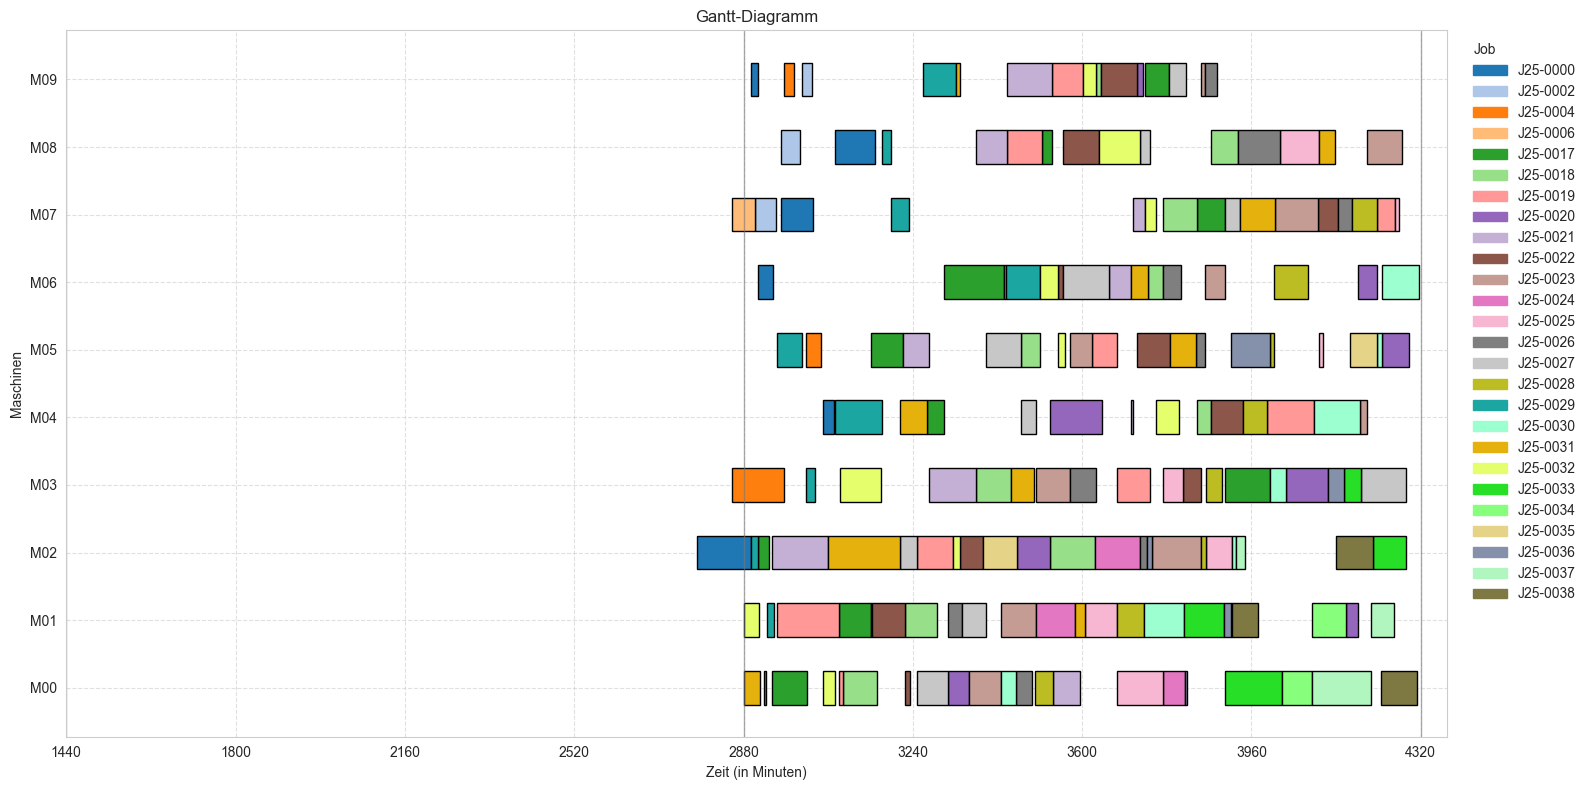

In [30]:
show.plot_gantt(df_execution2, perspective="Machine")

In [31]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0020,8,M07,1833,4295.0,72.0,96.0,4367.0,4391.0
1,J25-0024,3,M04,1997,4205.0,99.0,121.0,4304.0,4326.0
2,J25-0025,7,M06,2015,4316.0,89.0,77.0,4405.0,4393.0
3,J25-0028,8,M08,2161,4281.0,44.0,39.0,4325.0,4320.0
4,J25-0034,2,M03,2572,4288.0,76.0,90.0,4364.0,4378.0
5,J25-0037,3,M05,2654,4295.0,74.0,94.0,4369.0,4389.0


In [32]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0000,8,0,M00,76,75,1440,2062.0,2138.0
1,J25-0000,8,1,M01,69,75,1440,2299.0,2368.0
2,J25-0000,8,2,M03,76,75,1440,2532.0,2608.0
3,J25-0000,8,3,M05,51,75,1440,2608.0,2659.0
4,J25-0001,6,0,M01,46,123,1440,1867.0,1913.0
5,J25-0001,6,1,M00,37,123,1440,2025.0,2062.0
...,...,...,...,...,...,...,...,...,...
151,J25-0016,6,4,M06,32,1421,1440,1597.0,1629.0
152,J25-0016,6,5,M05,21,1421,1440,1653.0,1674.0
153,J25-0016,6,6,M09,32,1421,1440,1674.0,1706.0


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

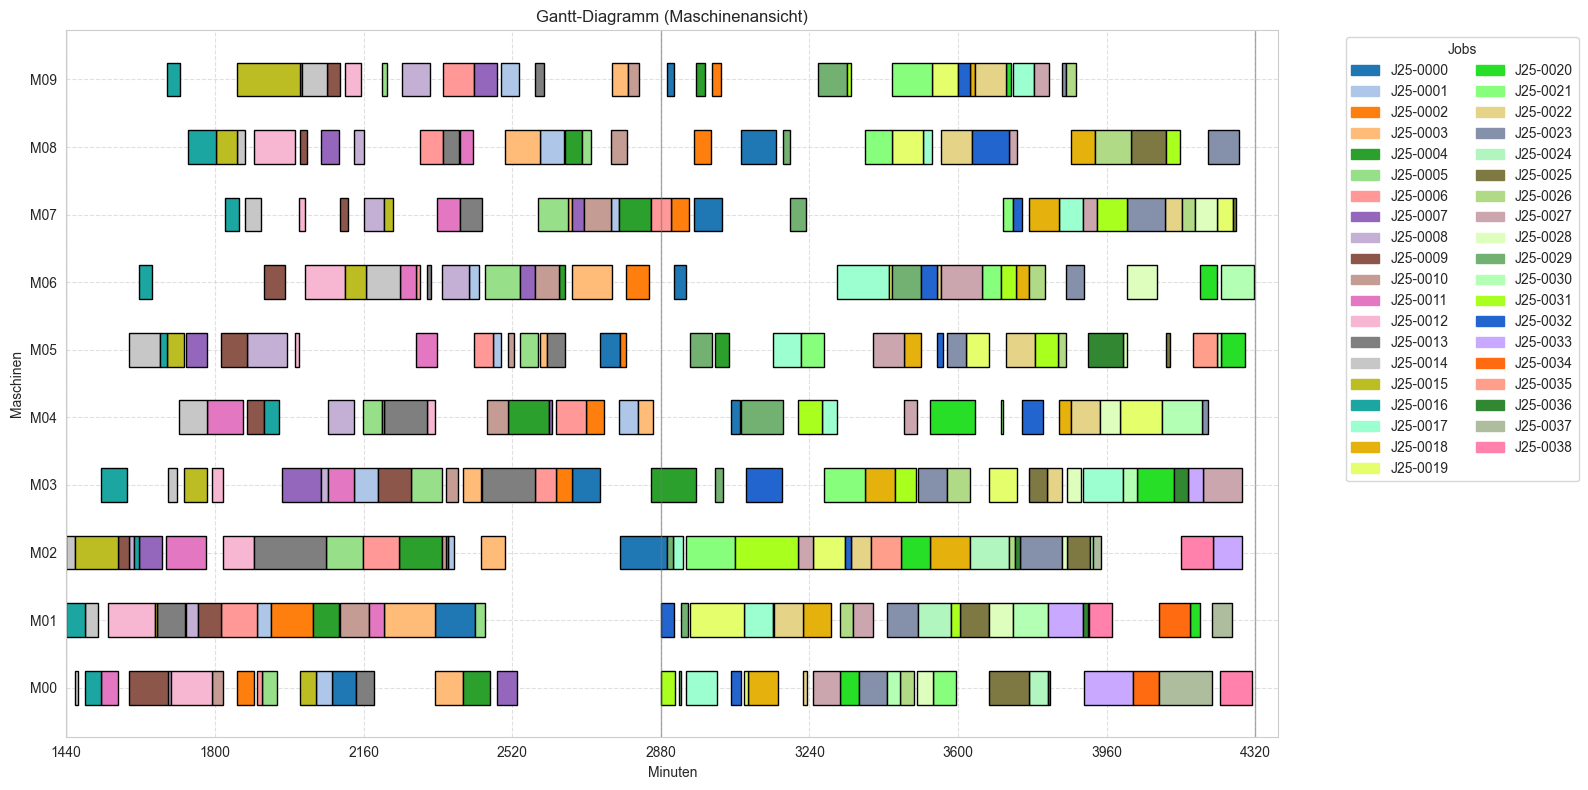

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [33]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)